# Install packages needed

https://docs.conda.io/projects/conda/en/latest/user-guide/tasks/manage-environments.html#deactivating-an-environment

https://stackoverflow.com/questions/41402409/tensorflow-doesnt-seem-to-see-my-gpu/71809780#71809780

https://stackoverflow.com/questions/65273118/why-is-tensorflow-not-recognizing-my-gpu-after-conda-install

https://jakevdp.github.io/blog/2017/12/05/installing-python-packages-from-jupyter/

https://discuss.tensorflow.org/t/found-conflicts-when-installing-spyder-in-an-environment-with-tensorflow-2-5/2718/3


https://docs.anaconda.com/anaconda/user-guide/tasks/tensorflow/

In [1]:
!conda list

# packages in environment at C:\Users\PFCva\anaconda3\envs\ppg_model:
#
# Name                    Version                   Build  Channel
_tflow_select             2.3.0                       gpu  
absl-py                   0.15.0             pyhd3eb1b0_0  
aiohttp                   3.8.1            py38h2bbff1b_1  
aiosignal                 1.2.0              pyhd3eb1b0_0  
argon2-cffi               21.3.0             pyhd3eb1b0_0  
argon2-cffi-bindings      21.2.0           py38h2bbff1b_0  
astor                     0.8.1            py38haa95532_0  
asttokens                 2.0.5              pyhd3eb1b0_0  
astunparse                1.6.3                      py_0  
async-timeout             4.0.1              pyhd3eb1b0_0  
attrs                     21.4.0             pyhd3eb1b0_0  
backcall                  0.2.0              pyhd3eb1b0_0  
blas                      1.0                         mkl  
bleach                    4.1.0              pyhd3eb1b0_0  
blinker              

# Load data 

In [2]:
import numpy as np
import pandas as pd

import pickle

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.preprocessing import StandardScaler

import tensorflow as tf

In [3]:
#check to make sure gpu is seen
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


In [4]:
data_dict = pd.read_pickle('E:/data_files/ppg_data/PPG_FieldStudy/S1/S1.pkl')

In [5]:
data_dict

{'rpeaks': array([    240,    1174,    2128, ..., 6447292, 6447748, 6448224]),
 'signal': {'chest': {'ACC': array([[ 0.85640001, -0.06779999, -0.36559999],
          [ 0.8556    , -0.06900001, -0.3646    ],
          [ 0.852     , -0.07020003, -0.3642    ],
          ...,
          [ 0.88759995, -0.1038    , -0.27920002],
          [ 0.88619995, -0.10159999, -0.27819997],
          [ 0.88680005, -0.10140002, -0.27380002]]),
   'ECG': array([[0.01560974],
          [0.01812744],
          [0.01753235],
          ...,
          [0.21368408],
          [0.21556091],
          [0.21702576]]),
   'EMG': array([[-1.5],
          [-1.5],
          [-1.5],
          ...,
          [-1.5],
          [-1.5],
          [-1.5]]),
   'EDA': array([[0.],
          [0.],
          [0.],
          ...,
          [0.],
          [0.],
          [0.]]),
   'Temp': array([[-273.15],
          [-273.15],
          [-273.15],
          ...,
          [-273.15],
          [-273.15],
          [-273.15]], dt

In [6]:
data_dict.keys()

dict_keys(['rpeaks', 'signal', 'label', 'activity', 'questionnaire', 'subject'])

In [7]:
data_dict['signal']['wrist']

{'ACC': array([[-0.765625, -0.078125,  0.671875],
        [-0.765625, -0.078125,  0.65625 ],
        [-0.765625, -0.078125,  0.671875],
        ...,
        [-0.375   , -0.015625,  0.9375  ],
        [-0.390625,  0.      ,  0.9375  ],
        [-0.375   ,  0.      ,  0.9375  ]]),
 'BVP': array([[  7.28],
        [  6.33],
        [  5.46],
        ...,
        [105.02],
        [109.44],
        [111.06]]),
 'EDA': array([[4.722437],
        [4.728843],
        [4.718594],
        ...,
        [3.170867],
        [3.159336],
        [3.151649]]),
 'TEMP': array([[32.13],
        [32.16],
        [32.16],
        ...,
        [34.37],
        [34.37],
        [34.37]])}

In [8]:
data_dict['signal']['wrist']['ACC'].shape

(294784, 3)

In [9]:
data_dict['signal']['wrist']['BVP'].shape

(589568, 1)

In [10]:
data_dict['signal']['wrist']['EDA'].shape

(36848, 1)

In [11]:
data_dict['signal']['wrist']['TEMP'].shape

(36848, 1)

In [12]:
data_dict['label'].shape[0]/.5

9206.0

In [13]:
data_dict['activity'].shape[0]/4

9212.0

# Notes
- data is stored in dict

- investigate for S1 to get a feel for how the data is structured

- given the different sampling rates (see below from readme file) the data is semi-structured/jaggad.

- there is data from both chest "RespiBAN" and wrist "E4" sensors.

## focus on the wrist/E4 sensor data

FROM REDME:
- ACC.csv: sampled at 32 Hz. The 3 data columns refer to the 3 accelerometer channels. Data is provided in units of 1/64g.
- BVP.csv: sampled at 64 Hz. Data from photoplethysmograph (PPG).
- EDA.csv: sampled at 4 Hz. Data is provided in μS.
- TEMP.csv: sampled at 4 Hz. Data is provided in °C"

- there was also some noted issue with user S6 so this data was truncated in the .pkl file to only include the valid data

# looking at the data in S1.pkl it appears that:

- ACC is in 3 channels measured @ 32Hz as stated but the units are in 1g not 1/64g in the rage [-2, 1.98]

- BVP appears to be @ 64Hz and raw output from the sensor in the rage [-1647.4, 1557.58]

- EDA (electrodermal activity) measured @ 4Hz in microS (microsiemens) in the rage of [2.2, 17.87]

- TEMP measured @ 4Hz in degC with a range of [29, 34.6]

- label (HR from ECG) measured as the mean over a rolling 8[second] window with a step of 2[second]. 
  This means that for the test window there is no value for HR for the first 7 seconds
  i.e. [na, na, na, HR1, HR2... HRn-3, na, na, na] with a frequency of 0.5Hz
  
- activity is the lable of the tast the user was performing this was applied recoded @ 4Hz. The sensor will not likley have   access to this info but might be helpful for segmening the data.

- questionnaire ('User_att') incldues info about the user (this may or may-not be avaliable to the sensor) this also includes the users
  skin tone which may be quite important to include 

- subject is the id of the user

- highest frequency signal is the BVP @ 64Hz and lowest is EDA and TEMP @ 4Hz, however label only avalable @ 0.5Hz


## TODO's:

    1. [complete] need to add a time stamp to each signal so they can be plotted and compaired 
    2. [complete] merge/contat them so that they all in a common data frame
    3. decide what to do with the frequency decrepancies:
        a. down sample the high frequency data to 0.5Hz
        b. interpolate the HR to higher frequency time stamps
        c. use a set of signals at a higher frequency (e.g. 4Hz) to predict the HR every 0.5Hz. (e.g. 8 sampling periods 
           per HR prediction)
        
        [Not a good idea need to retain the data in the higher frequency data. the lower frequency data TEMP and EDA could 
        likley use the mean value as a point estimate for an 8s span]
        
        

In [14]:
sensor_frequencies_Hz = {'ACC':32, 'BVP':64, 'EDA':4, 'TEMP':4,'HR':0.5, 'ACT_Label':4}

In [15]:
df = pd.DataFrame()
for i_key in sensor_frequencies_Hz.keys():
    #parse the key to the data name and correct level of the dict
    if (i_key=='HR'):
        lu_level = 0
        sgnl_lu = 'label'
    elif(i_key=='ACT_Label'):
        lu_level = 0
        sgnl_lu = 'activity'
    else:
        lu_level = 2
        sgnl_lu = i_key
        
    #get number of signal points
    if (lu_level==0):
        i_data = data_dict[sgnl_lu].reshape(-1,1)
    else:
        i_data = data_dict['signal']['wrist'][sgnl_lu]
    
    N = len(i_data)
    
    #get time_step & end time
    time_step_act = 1/sensor_frequencies_Hz[i_key]
    end_time = time_step_act*N
    
    #calc all time stamps
    time_stamps = np.linspace(time_step_act, end_time, N, endpoint=True)
    
    #due the the sliding window approach an offset is needed for the HR signal
    # (first value will be 2 in the data set (sampling rate of 0.5Hz) 
    # this should be 8s as it is the average of an 8s window)
    if (i_key=='HR'):
        time_stamps = time_stamps + (8 - (time_stamps[0])) 
    
    
    new_dict = {'timestamp_s':time_stamps}
    
    for k in range(i_data.shape[1]):
        i_k_key = i_key + '_' + str(k)
        new_dict[i_k_key] = i_data[:,k]
        
    df = df.join(pd.DataFrame(new_dict).set_index('timestamp_s'),how='outer')

In [16]:
df[(~df.HR_0.isnull())]

,ACC_0,ACC_1,ACC_2,BVP_0,EDA_0,TEMP_0,HR_0,ACT_Label_0
timestamp_s,,,,,,,,
8.0,-1.015625,-0.078125,0.140625,-4.28,4.757029,32.15,49.611369,0.0
10.0,-1.031250,-0.156250,0.171875,40.85,4.783934,32.15,50.323992,0.0
12.0,-0.984375,-0.218750,0.296875,88.51,4.722437,32.13,52.708336,0.0
14.0,-0.250000,-0.843750,0.453125,-117.08,4.932550,32.13,55.640794,0.0
16.0,-0.671875,0.265625,0.703125,122.05,4.864648,32.15,57.658406,0.0
...,...,...,...,...,...,...,...,...
9204.0,-0.500000,1.171875,0.328125,-33.53,3.210271,34.37,74.058629,0.0
9206.0,-0.390625,0.984375,0.296875,-224.57,3.207708,34.39,80.442006,0.0
9208.0,-0.296875,0.250000,1.000000,166.55,3.734585,34.37,84.004991,0.0


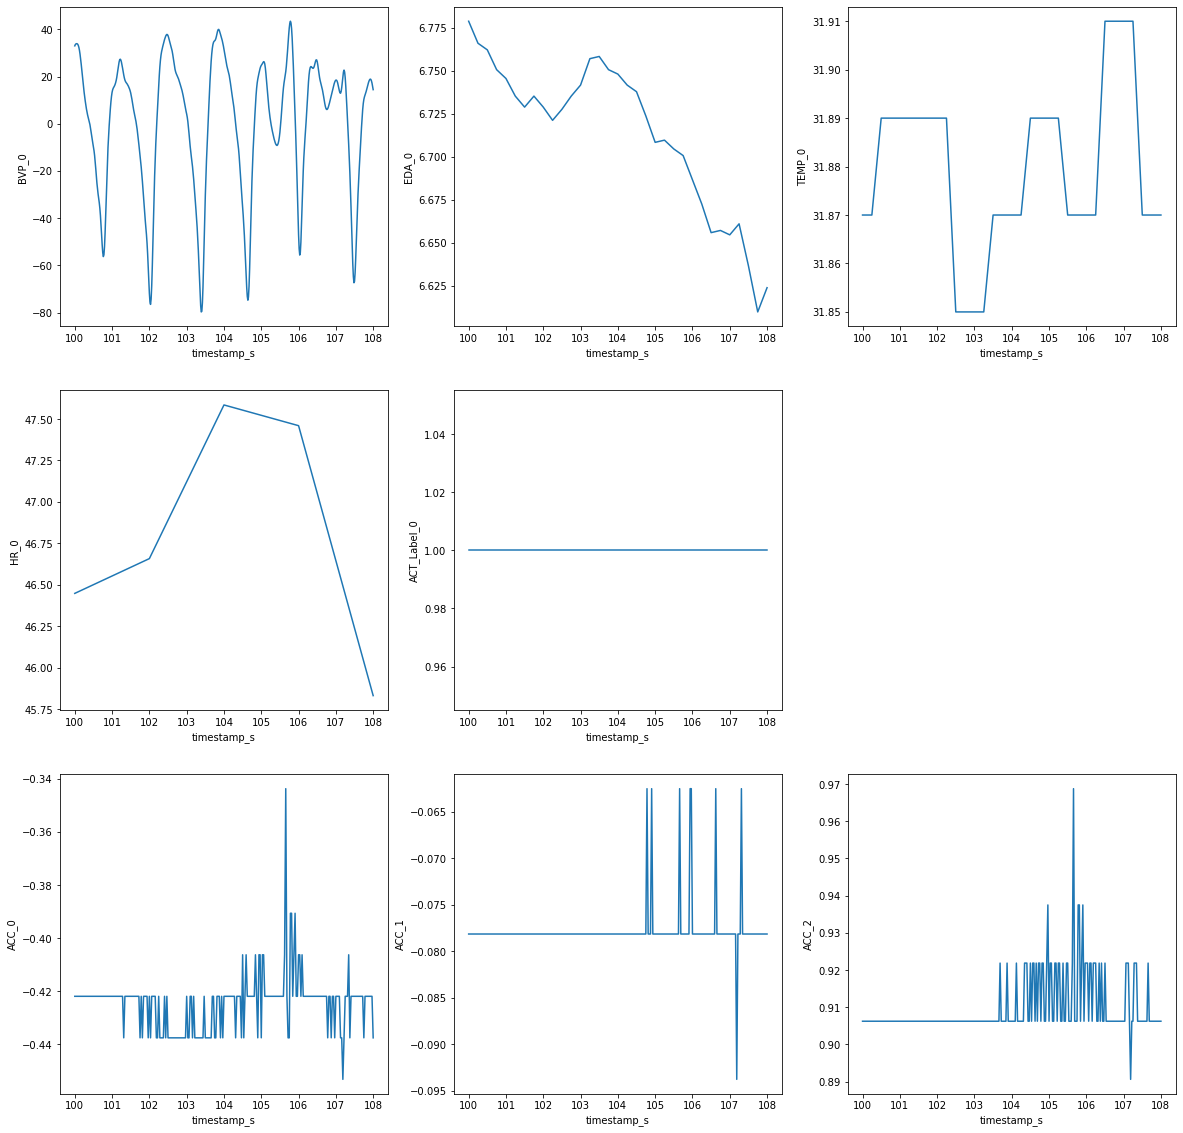

In [17]:
start_time = 100#[seconds]
time_span = 8#[seconds]
end_time = start_time + time_span #[seconds]
d = df.loc[start_time:end_time,:]

plt.figure(figsize=(20,20))
plt.subplot(3,3,1)
sns.lineplot(data=d[~d.BVP_0.isnull()].BVP_0)
plt.subplot(3,3,2)
sns.lineplot(data=d[~d.EDA_0.isnull()].EDA_0)
plt.subplot(3,3,3)
sns.lineplot(data=d[~d.TEMP_0.isnull()].TEMP_0)
plt.subplot(3,3,4)
sns.lineplot(data=d[~d.HR_0.isnull()].HR_0)
plt.subplot(3,3,5)
sns.lineplot(data=d[~d.ACT_Label_0.isnull()].ACT_Label_0)

plt.subplot(3,3,7)
sns.lineplot(data=d[~d.ACC_0.isnull()].ACC_0)
plt.subplot(3,3,8)
sns.lineplot(data=d[~d.ACC_1.isnull()].ACC_1)
plt.subplot(3,3,9)
sns.lineplot(data=d[~d.ACC_2.isnull()].ACC_2);

# test out fft and get working on sample data set

In [18]:
from scipy.fft import rfft, rfftfreq, irfft
from scipy.interpolate import pchip_interpolate

In [19]:
def timeSeries_interpolater(t,S,N):
    
    #sample the signal at Fs to allow for sampling/fft on a consistant basis
    #calculate the time stamps to interpolat on to get the signal starting at t[0] and ending at t[-1] the specified Fs
    ti = np.linspace(t[0], t[-1], N)#int(np.ceil((t[-1]-t[0])*Fs))+1
    
    # use a cubic spline to interpolate the data on to the calculated ti
    Si = pchip_interpolate(t,S,ti)
    
    return (ti, Si)

In [20]:
def dfft_brickwall_filtering(t, signal, lowF_brickwall=None, highF_brickwall=None):
    
    #get length of signal
    N = len(signal)
    
    # determine the sampling rate for the signal
    Ts = np.diff(t).mean()
    Fs = 1/Ts
    
    # calculate frequency bins for fft
    xf = rfftfreq(N, Ts)
    
    # perform fft
    yf = rfft(signal, N)
    
    # calculate power for each frequency bin
    power = (np.real(yf*np.conj(yf)))/N
    
    # if no filtering then go straight to output
    if ((lowF_brickwall != None) | (highF_brickwall != None)):
    
        # copy fft so that power loss can be compensated for
        yf_filtered = yf.copy()
        
        #apply high-pass and low pass brick-walls
        if (lowF_brickwall == None):
            lowF_brickwall = 0
        else:
            yf_filtered[xf < lowF_brickwall] = 0
            
        if (highF_brickwall == None):
            highF_brickwall = max(xf)
        else:
            yf_filtered[xf > highF_brickwall] = 0
    
        # calculate power remaning in filtered spectrum
        power_f = (np.real(yf_filtered*np.conj(yf_filtered)))/N
        
        # calculate loss factor
        if (sum(power_f) == 0):
            power_correction_factor = 1
        else:
            power_correction_factor = sum(power)/sum(power_f)

        # correct the filtered fft for the power loss due to brick wall filtering
        yf_filtered = yf_filtered*power_correction_factor
        
        # get the number of non-zero elements in yf
        num_nonZero_yfs = len(xf[(lowF_brickwall<xf) & (xf<highF_brickwall)])
        return xf, yf_filtered
    else:
        return xf, yf

In [21]:
def signal2spect(user_dataframe, sig_key, endT, tspan=8, N=512, hf_brickwall=8):
    end_time = endT #[seconds]
    time_span = tspan #[seconds]
    start_time = end_time - time_span #[seconds]
    
    d = user_dataframe.loc[start_time:end_time,:]
    dS = d[~d[sig_key].isnull()][sig_key]
    
    t0 = dS.index.values
    S = dS.values

    (ti, Si) = timeSeries_interpolater(t0,S,N)
    
    (xf, yf) = dfft_brickwall_filtering(t=ti, signal=Si, highF_brickwall=hf_brickwall)
    
    return (xf, yf, ti, Si)

512


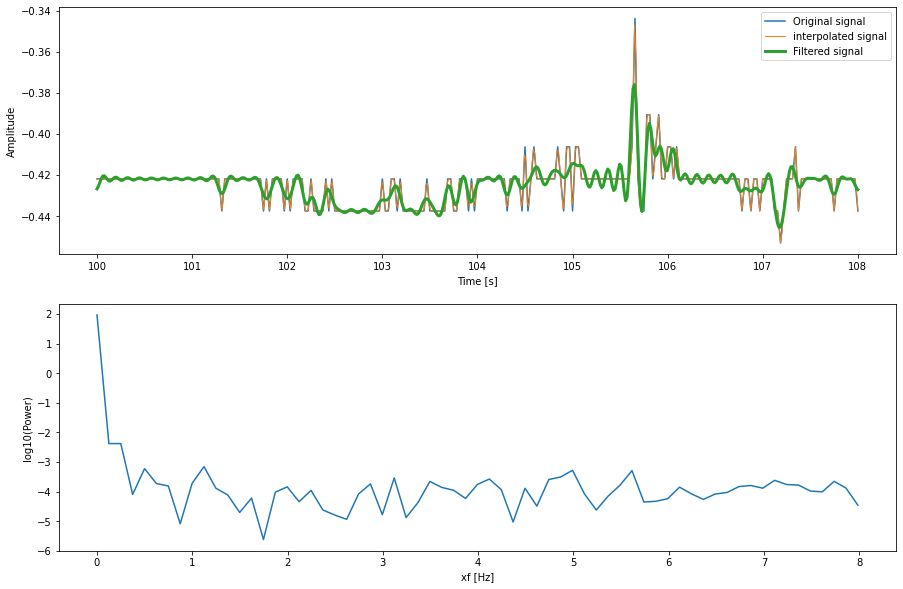

In [22]:
Skey = 'ACC_0'
start_time = 100#[seconds]
time_span = 8#[seconds]


end_time = start_time + time_span #[seconds]
d1 = df.loc[start_time:end_time,:]
d2 = d1[~d1[Skey].isnull()][Skey]
t0 = d2.index.values
S = d2.values

(xf, yf, ti, Si) = signal2spect(user_dataframe=df, sig_key=Skey, endT=end_time, N=512)
print(len(ti))

Sf = irfft(yf, len(ti))

plt.figure(figsize=(15,10))

plt.subplot(2,1,1)
plt.plot(t0, S, label='Original signal')
plt.plot(ti, Si, linewidth=1, label='interpolated signal')
plt.plot(ti, Sf, linewidth=3, label='Filtered signal')
plt.xlabel('Time [s]')
plt.ylabel('Amplitude')
plt.legend(loc='best')

plt.subplot(2,1,2)
plt.plot(xf[yf!=0],np.log10(np.real(yf[yf!=0]*np.conj(yf[yf!=0]))/len(ti)));
plt.xlabel('xf [Hz]')
plt.ylabel('log10(Power)')

plt.show()

In [23]:
len(yf[yf!=0])

65

In [24]:
yf[0]/len(ti)

(-0.42450178250228493+0j)

# Select features and collate them on 0.5Hz for each subject 
   (0.5[Hz] isthe frequency at which we have the label)

features:
   1. BVP spectra
   2. ACC_0 spectra
   3. ACC_1 spectra
   4. ACC_2 spectra
        
        Note: each of the above specctra consits of a vector of 65 values they all share a xf vector
        (if use 8Hz upper cut off and 64 Hz sampling rate)
        
   
   5. skin TEMP mean over window
   6. EDA mean over window
    

In [25]:
label_df = df[~df['HR_0'].isnull()]['HR_0'].reset_index()

user_id = 'S1'
window_timespan = 8
target_sample_num_points=2**9 #512 this is 64Hz for an 8second window

S1_processed_df = pd.DataFrame()
for row in label_df.iterrows():
    row_df = pd.DataFrame(columns=['time_stamp[sec]','user_id', 'activity_label', 'gt_heart_rate[BPM]', 'skin_temp[C]', 'EDA[microS]', 'fft_N'
                                   , 'fft_xf', 'BVP_powerSpect', 'ACC0_powerSpect', 'ACC1_powerSpect', 'ACC2_powerSpect'])
    # get anchor ts
    row_df.loc[0,'time_stamp[sec]'] = row[1][0]
    
    #get activity code for segmentation of data later
    row_df.loc[0,'activity_label'] = df.loc[8,'ACT_Label_0']
    
    # get label value
    row_df.loc[0,'gt_heart_rate[BPM]'] = row[1][1]
    
    window_et = row_df['time_stamp[sec]'][0]
    window_st = window_et - window_timespan
    
    # from full data frame extract:
    
    # mean skin TEMP
    row_df.loc[0,'skin_temp[C]'] = df.loc[window_st:window_et,'TEMP_0'].mean()
    
    # mean EDA
    row_df.loc[0,'EDA[microS]'] = df.loc[window_st:window_et,'EDA_0'].mean()
    
    
    # BVP spectra
    (xf_bvp, yf_bvp, t_bvp) = signal2spect(user_dataframe=df, sig_key='BVP_0', endT=window_et
                                        , tspan=window_timespan, N=target_sample_num_points)[0:3]
    
    row_df.loc[0,'fft_N'] = len(t_bvp)

    
    row_df.at[0,'fft_xf'] = xf_bvp[yf_bvp!=0]
    '''this vector (x_f) should be ~ the same for all spectra.
    NOTE: There may be a samll frequency shifs due to the starting point being for other series being different.
    This difference will be less than Ts for the signal in question. Could fix this by passing a consitant t vector
    to all interpolators but would then cause a slight extraploation on to the earliest point. given this will be a 
    distributed shitf and it will not effect shape of the power spectra this wil be ignored unless it proves to be an issue'''
    
    y_temp = yf_bvp[yf_bvp!=0]
    row_df.at[0, 'BVP_powerSpect'] = np.real(y_temp*np.conj(y_temp))/row_df.loc[0,'fft_N'] 
    
    
    # ACC_0 spectra
    (yf_acc0) = signal2spect(user_dataframe=df, sig_key='ACC_0', endT=window_et
                                        , tspan=window_timespan, N=target_sample_num_points)[1]
    y_temp = yf_acc0[yf_acc0!=0]
    row_df.at[0, 'ACC0_powerSpect'] = np.real(y_temp*np.conj(y_temp))/row_df.loc[0,'fft_N'] 
    
    # ACC_1 spectra
    (yf_acc1) = signal2spect(user_dataframe=df, sig_key='ACC_1', endT=window_et
                                        , tspan=window_timespan, N=target_sample_num_points)[1]
    y_temp = yf_acc1[yf_acc1!=0]
    row_df.at[0, 'ACC1_powerSpect'] = np.real(y_temp*np.conj(y_temp))/row_df.loc[0,'fft_N'] 
    
    # ACC_2 spectra
    (yf_acc2) = signal2spect(user_dataframe=df, sig_key='ACC_2', endT=window_et
                                        , tspan=window_timespan, N=target_sample_num_points)[1]
    y_temp = yf_acc2[yf_acc2!=0]
    row_df.at[0,'ACC2_powerSpect'] = np.real(y_temp*np.conj(y_temp))/row_df.loc[0,'fft_N'] 
    
    
    # concat row onto df
    S1_processed_df = pd.concat([S1_processed_df,row_df])
        

S1_processed_df['user_id'] = user_id
        
S1_processed_df = S1_processed_df.reset_index().drop(columns=['index'])
S1_processed_df


,time_stamp[sec],user_id,activity_label,gt_heart_rate[BPM],skin_temp[C],EDA[microS],fft_N,fft_xf,BVP_powerSpect,ACC0_powerSpect,ACC1_powerSpect,ACC2_powerSpect
0,8.0,S1,0.0,49.611369,32.148125,4.716872,512,"[0.0, 0.125, 0.25, 0.375, 0.5, 0.625, 0.75, 0....","[2424.0293932209092, 2453.401250711232, 3345.5...","[365.3205752728728, 1.2925030290711086, 0.2982...","[14.216309637574813, 3.1416883726455733, 1.345...","[108.00485114501416, 9.093874371543059, 0.1811..."
1,10.0,S1,0.0,50.323992,32.148788,4.728222,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[6432.553566355553, 25951.961688215106, 1035.5...","[419.06593727355886, 1.5333317186586135, 0.345...","[15.147128375915065, 2.696696914672375, 1.6246...","[55.672249292732474, 6.617353572548366, 2.8159..."
2,12.0,S1,0.0,52.708336,32.14697,4.739054,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[5.4233734030078855, 16188.623130957985, 3785....","[471.49234931769234, 0.5636890869732002, 0.231...","[18.963962320188436, 2.5815064237844796, 1.026...","[22.434022488934644, 0.634680168052862, 0.2299..."
3,14.0,S1,0.0,55.640794,32.144545,4.78867,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[588.9137670452351, 14929.560140836436, 452.26...","[393.721217193165, 6.543052337290078, 4.239267...","[39.10317456716967, 11.359003273662529, 5.2687...","[24.384978601521848, 1.0892436191061756, 0.417..."
4,16.0,S1,0.0,57.658406,32.143939,4.83025,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[21536.357773713473, 48364.85820653735, 31359....","[317.72135325865145, 12.925369923092294, 2.332...","[37.2499644010359, 16.342178029680124, 9.97887...","[55.727174596371036, 6.36003933311807, 2.10497..."
...,...,...,...,...,...,...,...,...,...,...,...,...
4598,9204.0,S1,0.0,74.058629,34.38697,2.816561,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[175.07816038024728, 2264.036542040151, 11759....","[136.09400398202558, 2.5164527364381133, 0.813...","[107.31973486383777, 46.504905684250275, 0.111...","[146.2208697832246, 14.168628520587658, 0.9454..."
4599,9206.0,S1,0.0,80.442006,34.385152,2.962033,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[28.66954094326583, 1836.1741111924919, 15508....","[95.77157063263073, 3.642924350805574, 5.05908...","[242.78153568101612, 21.650033719011336, 12.18...","[71.93100332809225, 3.204878942505541, 2.59125..."
4600,9208.0,S1,0.0,84.004991,34.379697,3.134195,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[22585.43919647643, 18492.811983565975, 26373....","[89.20240652925077, 2.0058596289271273, 4.0383...","[275.9084268386968, 14.178541263442042, 9.2643...","[76.05446691241173, 4.416965759725867, 3.46623..."
4601,9210.0,S1,0.0,85.796257,34.376061,3.320508,512,"[0.0, 0.124755859375, 0.24951171875, 0.3742675...","[77.8691985585985, 1442.1472013425227, 1004.33...","[90.29906955287623, 1.9670054650218036, 3.3746...","[135.81892559086407, 39.19077319048659, 1.0684...","[151.19637847572406, 18.69381933378424, 0.6284..."
